<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Seminary_UM6P_Jan_2025_Part_5_More_advanced_axisymmetric_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

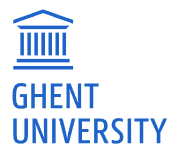<br>


**Axisymmetric Flow in Multilayer Aquifer Systems**<br>
Seminary on Groundwater Modeling<br>
University Mohammed VI Polytechnic<br>
January 6, 2025<br>
Dr. Andy Louwyck

---



---

# **Part 5 - More Advanced Axisymmetric Models**

This notebook contains code examples of the Cooper et al. (1967) and Butler (1988) models discussed in the fifth part of the presentation. The explanations provided with each example are relatively concise. To gain a good understanding of what's going on, I recommend reading the notebook side by side with the slides. For a full comprehension of the discussed models, I refer to [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023).

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

Importing module `inspect` will allow us to print the source code of the functions implemented in the `maxsypy` package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

We also clone the MAxSyPy package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy


# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 142 (delta 34), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (142/142), 6.18 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (68/68), done.


The [MAxSyPy](https://github.com/alouwyck/maxsypy) package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023). We will also use the [TTim](https://ttim.readthedocs.io/en/latest) package:

In [3]:
!pip install ttim -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00


In [4]:
import ttim

## 1. The Cooper et al. model

To simulate a slug test in a confined aquifer, the Cooper et al. method may be used, which is implemented in function `cooper`:

In [5]:
from maxsypy.special import cooper

print(inspect.getdoc(cooper))

Simulate a slug test conducted in a finite-diameter well fully penetrating a confined aquifer.

The function applies the Stehfest algorithm to numerically invert the Laplace transform.

Parameters
----------
rc : float
   Radius [L] of the well-casing.
rw : float
   Radius [L] of the well-screen.
H0 : float
   Initial and instantaneous head change [L] in the well.
T : float
  Aquifer transmissivity [L²/T].
S : float
  Aquifer storativity [-].
t : array_like
  One-dimensional array with the simulation times [T].
r : array_like, default: `None`
  Radial distances [L]. If `None`, head change in the well is simulated.
ns : int, default: `12`
   Number of Stehfest parameters

Returns
-------
s : ndarray
  Head change [L] at distances `r` and times `t`.
  The shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
  If `r` is `None`, then the shape of `s` is `(nt, )`.


We see that the function applies the Stehfest algorithm to numerically invert the solution in Laplace space. Besides calculating the head change in the tested well, it is also possible to simulate the head change in an observation well.

If we adopt the example from previous notebooks, we need to define an initial head change `H0` in the tested well instead of a constant pumping rate. Additionally, we also need the radius of the well-screen `rw` and the radius of the well-casing `rc`. The latter is used to take into account the change in wellbore storage.

In [6]:
H0 = 0.5     # initial head change (m) in the well
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)
rw = 0.05    # well-screen radius (m)
rc = 0.1     # well-casing radius (m)

Let's simulate a slug test in the well and simulate the head change in this well and in an observation well at 1 m from the tested well:

In [7]:
t = np.logspace(-7, 0, 100)  # simulation times (d)
sw = cooper(rc=rc, rw=rw, H0=H0, T=T, S=S, t=t)  # head change (m) in the well
r_obs = 1  # observation well at 1 m
s  = cooper(rc=rc, rw=rw, H0=H0, T=T, S=S, t=t, r=r_obs)  # head change (m) in observation well

We perform the same simulation using **TTim**. In this case, the instantaneous head change $H_0$ in the well is converted into an initial volume $V_0$ using the following equation:

> $V_0 = \pi r^2_c H_0$

where $r_c$ is the radius of the well-casing where the head change takes place. The wellbore storage simulation type `wbstype` is set to `'slug'`:

In [8]:
model = ttim.ModelMaq(z=[1, 0], kaq=T, Saq=S, tmin=t[0], tmax=t[-1])
V0 = np.pi * rc**2 * H0  # initial volume V0 (m³) due to instantaneous head change H0
w = ttim.Well(model, tsandQ=[(0, -V0)], rw=rw, rc=rc, wbstype='slug')  # slug test well
model.solve()
sw_ttim = w.headinside(t)  # head change (m) inside the tested well
s_ttim = model.head(x=0, y=r_obs, t=t)  # head change (m) in observation well

self.neq  1
solution complete


Let's plot the result of both simulations:

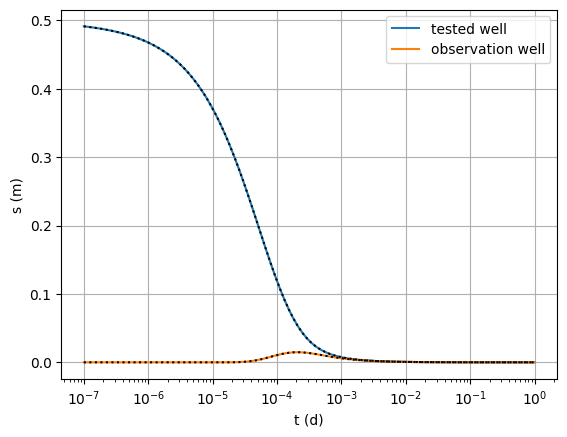

In [9]:
# cooper et al.
plt.semilogx(t, sw.squeeze(), label="tested well");
plt.semilogx(t, s.squeeze(), label="observation well");

# ttim
plt.semilogx(t, sw_ttim.squeeze(), 'k:');
plt.semilogx(t, s_ttim.squeeze(), 'k:');

plt.legend();
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

The TTim solution (black dotted curves) is virtually the same as the Cooper et al. solution (colored curves). Notice the effect of the slug test is almost not visible anymore in the observation well.

## 2. The Butler model

The Butler model extends the Theis solution by allowing for a finite-thickness skin surrounding the well-screen.

We import function `butler` and function `theis` as we will compare the first with the latter:

In [10]:
from maxsypy.special import butler, theis

print(inspect.getdoc(butler))

Simulate transient flow to a pumping well in a confined aquifer, which extracts water at a constant pumping rate.
The pumping well has a finite-thickness skin.

The function applies the Stehfest algorithm to numerically invert the Laplace transform.

Parameters
----------
r : array_like
  One-dimensional array with the radial distances [L].
t : array_like
  One-dimensional array with the simulation times [T].
R : float
   Radius [L] of well-skin (well-radius is zero)
T : array_like
  Skin and aquifer transmissivities [L²/T], so T = [T_skin, T_aquifer]
S : array_like
  Skin and aquifer storativities [-], so S = [S_skin, S_aquifer]
Q : float
  Pumping rate [L³/T] of the well.
ns : int, default: `12`
   Number of Stehfest parameters

Returns
-------
s : ndarray
  Drawdown [L] at distances `r` and times `t`.
  The shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.


Again, we consider the same example, and this time we also need the well radius `rw` and the radius of the skin `Rs`:

In [11]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)
rw = 0.05    # well-screen radius (m)
Rs = 0.5     # well-skin radius (m)

First, let's simulate a **positive skin effect** by assigning a transmissivity `Ts` to the skin zone which is two times smaller than the aquifer transmissivity `T`. The exact solution is given by Butler's model, while an approximate solution is obtained by applying the Theis equation and the dimensionless skin factor $F$:

> $F = \dfrac{T}{T_s}\ln\dfrac{r_w}{R_s}$

The drawdown in the well $s_w$ is approximated as follows:

> $s_w(t) \approx s(R_s,t) + \dfrac{Q}{2 \pi T} F$

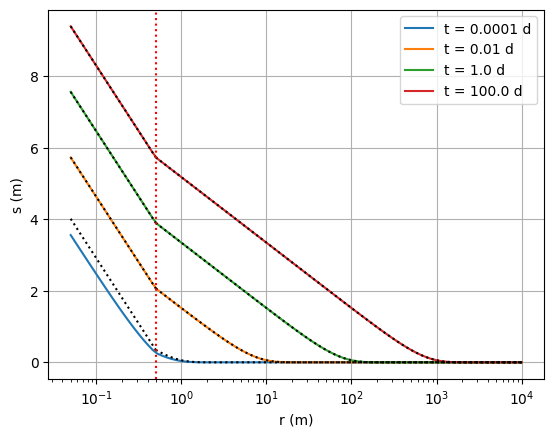

In [12]:
# positive skin effect: skin is less pervious

Ts = T / 2   # well-skin transmissivity (m²/d)

t = np.logspace(-4, 2, 4)  # simulation times (d)
r = np.logspace(np.log10(rw), 4, 100)  # radial distances (m)
s_but = butler(r=r, t=t, R=Rs, T=[Ts, T], S=[S, S], Q=Q)  # drawdown (m) according to Butler
plt.semilogx(r, s_but);
plt.legend(['t = ' + str(t) + " d" for t in t]);

r_aq = np.logspace(np.log10(Rs), 4, 100)  # radial distances (m) in aquifer, i.e. r >= Rs
s_th = -theis(r=r_aq, t=t, T=T, S=S, Q=Q)  # drawdown (m) according to Theis
plt.semilogx(r_aq, s_th, 'k:');

F = T / Ts * np.log(rw / Rs)  # dimensionless skin factor
sw = s_th[0, :] + Q / 2 / np.pi / T * F  # drawdown (m) in the well
plt.semilogx([rw, Rs], np.vstack((sw, s_th[0, :])), 'k:');  # line connecting sw and s_th at distance Rs

yl = plt.ylim()
plt.semilogx([Rs, Rs], yl, 'r:');  # skin radius (m)
plt.ylim(yl);
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');

We see the approximation that uses the Theis equation and the dimensionless skin factor is virtually the same as the exact solution for large values of time. Note that the curves visualizing the approximate solution consist of two parts:
1. the drawdown curve for the aquifer simulated using the Theis equation, and
2. the straight line connecting the drawdown at the outer radius $R_s$ of the skin to the drawdown inside the well, which is the drawdown at distance $r_w$.

Let's simulate the opposite case where the skin transmissivity `Ts` is two times the aquifer transmissivity `T`, which results in a **negative skin effect**:

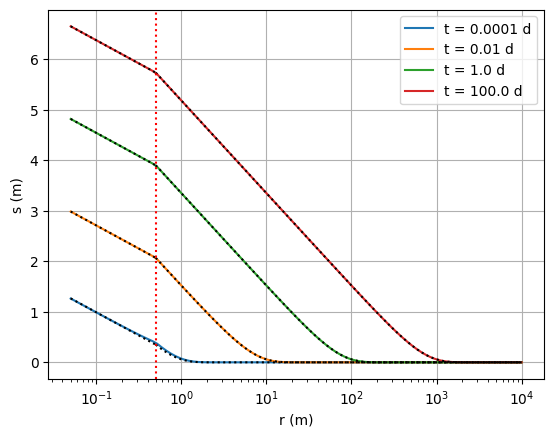

In [13]:
# negative skin effect: skin is more permeable

Ts = T * 2   # well-skin transmissivity (m²/d)

s_but = butler(r=r, t=t, R=Rs, T=[Ts, T], S=[S, S], Q=Q)  # drawdown (m) according to Butler
plt.semilogx(r, s_but);
plt.legend(['t = ' + str(t) + " d" for t in t]);

s_th = -theis(r=r_aq, t=t, T=T, S=S, Q=Q)  # drawdown (m) according to Theis
plt.semilogx(r_aq, s_th, 'k:');

F = T / Ts * np.log(rw / Rs)  # dimensionless skin factor
sw = s_th[0, :] + Q / 2 / np.pi / T * F  # drawdown (m) in the well
plt.semilogx([rw, Rs], np.vstack((sw, s_th[0, :])), 'k:');  # line connecting sw and s_th at distance Rs

yl = plt.ylim()
plt.semilogx([Rs, Rs], yl, 'r:');  # skin radius (m)
plt.ylim(yl);
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');

The negative skin effect is less pronounced, and as a result, the exact and the approximate solutions coincide for all simulation times.

Using **TTim**, it also possible to simulate the skin effect by defining a zero-thickness resistance $c_s$ of the well-screen:

> $Q = 2 \pi r_w L \dfrac{h_w-h_s}{c_s}$

with $L$ the length of he screen, and $h_w$ and $h_s$ the head inside the well and at the outer radius $R_s$ of the skin, respectively.

Using the Thiem equation, the well discharge can also be expressed as:

> $Q = 2 \pi T_s \dfrac{h_w-h_s}{\ln\dfrac{r_w}{R_s}}$

As the right-hand side of both equations are identical, $c_s$ must be equal to:

> $c_s = \dfrac{r_w L}{T_s} \ln\dfrac{r_w}{R_s}$



Now we know how to calculate the well-screen resistance, let's build and simulate the equivalent TTim model:

In [14]:
model = ttim.ModelMaq(kaq=T, Saq=S, z=[1, 0], tmin=t[0], tmax=t[-1])
cs = rw / Ts * np.log(rw / Rs)  # well-screen resistance (d), with L = 1 m
well = ttim.Well(model, tsandQ=[(0, -Q)], rw=rw, res=cs)
model.solve()

s_ttim = -np.array([model.head(0, r, t) for r in r_aq]).squeeze()  # drawdown in aquifer (m)
sw_ttim = -well.headinside(t)  # drawdown inside the well (m)

self.neq  1
solution complete


Plotting the results of both simulations:

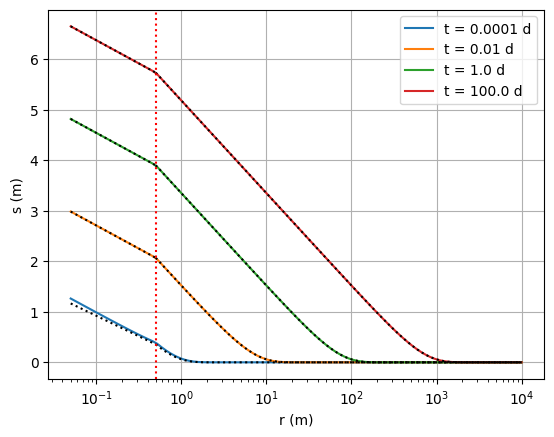

In [15]:
plt.semilogx(r, s_but);  # drawdown (m) according to butler
plt.legend(['t = ' + str(t) + " d" for t in t]);
plt.semilogx(r_aq, s_ttim, 'k:');  # drawdown (m) according to ttim
plt.semilogx([rw, Rs], np.vstack((sw_ttim, s_ttim[0, :])), 'k:');  # line connecting sw and s_ttim at Rs
yl = plt.ylim()
plt.semilogx([Rs, Rs], yl, 'r:');  # skin radius (m)
plt.ylim(yl);
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');

As with the approximate solution that superimposes the Theis equation and the skin effect derived from the skin factor, the TTim curves also consist of two parts: the drawdown curve for the aquifer and the straight line connecting the drawdown at the outer radius of the skin to the drawdown inside the well. For large values of time, we notice the TTim solution assuming a zero-thickness skin approximates the exact Butler solution very well.

---